**Подключение библиотек и скриптов**

In [617]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [618]:
import warnings
warnings.filterwarnings('ignore')

In [619]:
matplotlib.rcParams.update({'font.size': 10})

**Функция подсчета метрики R2**

In [620]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [621]:
TRAIN_DATASET_PATH = 'reppm/train.csv'
TEST_DATASET_PATH = 'reppm/test.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [622]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


In [623]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [624]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B


In [625]:
train_df.shape

(10000, 20)

In [626]:
test_df.shape

(5000, 19)

### Приведение типов

In [627]:
train_df['Id'] = train_df['Id'].astype(str)
#train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df.dtypes

Id                object
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

## EDA  <a class='anchor' id='eda'>
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

**Целевая переменная**

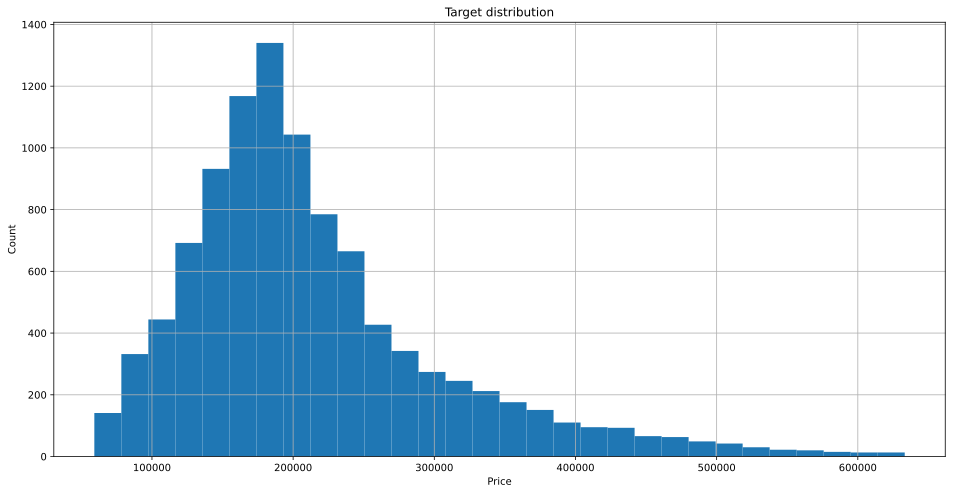

In [628]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [629]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Номинативные переменные**

In [630]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [631]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [632]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [633]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [634]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов  <a class='anchor' id='outlier'>

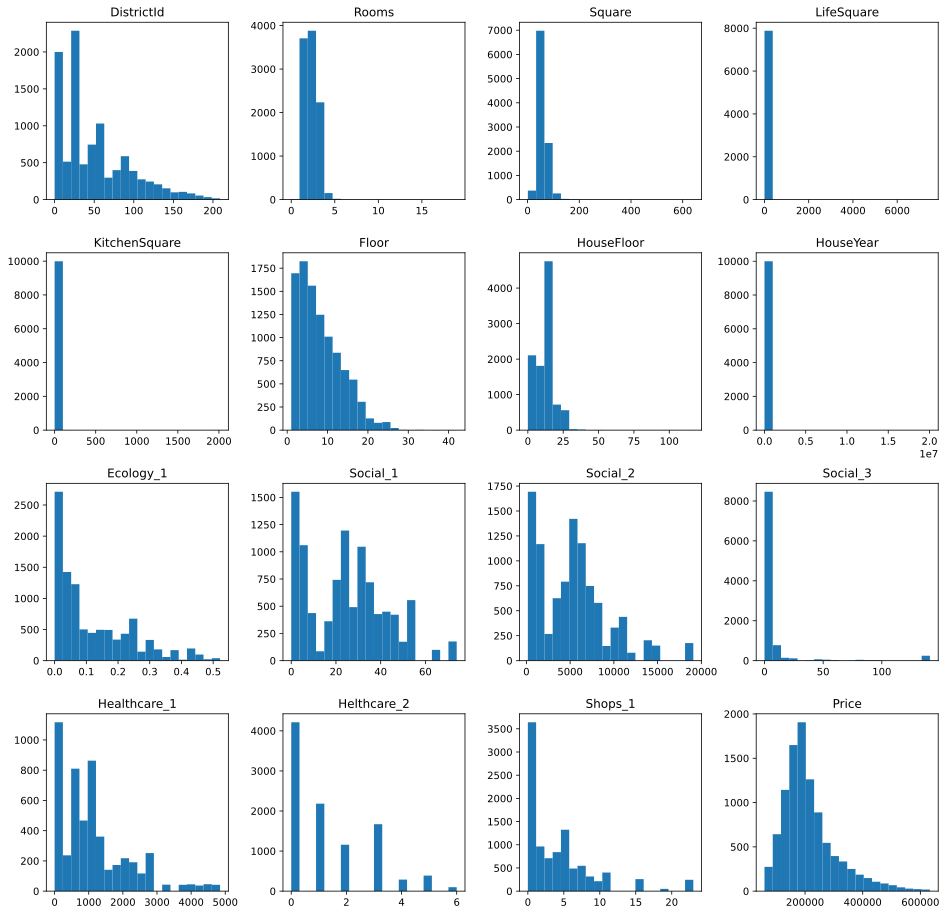

In [635]:
train_df.hist(figsize=(16, 16), bins=20, grid=False);

#### Square

Для признака площадь квартиры есть выбросы слева и справа

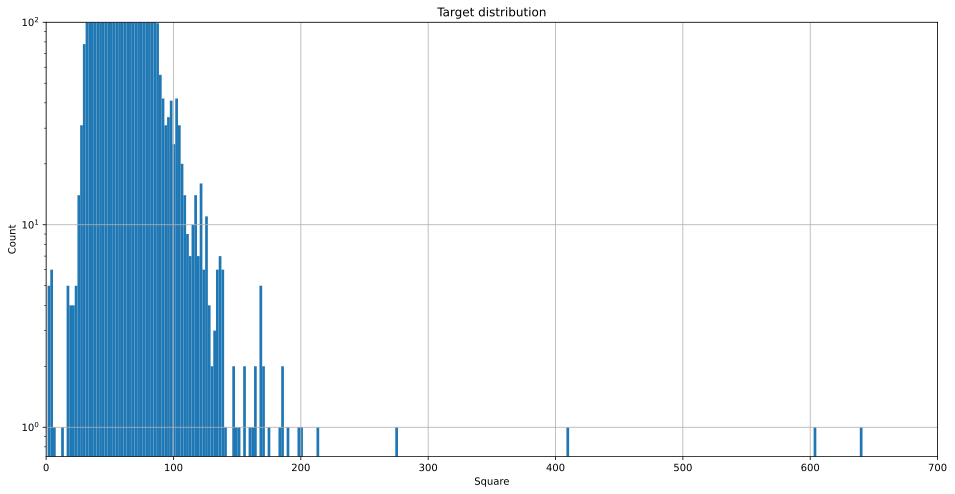

In [636]:
plt.figure(figsize = (16, 8))

train_df['Square'].hist(bins=300)
plt.ylabel('Count')
plt.xlabel('Square')
plt.yscale(value="log")
plt.axis([0, 700, 0, 100])
plt.title('Target distribution')
plt.show()

Для жилой площади также есть выбросы, обработаем их позже, когда будем обрабатывать пропуски

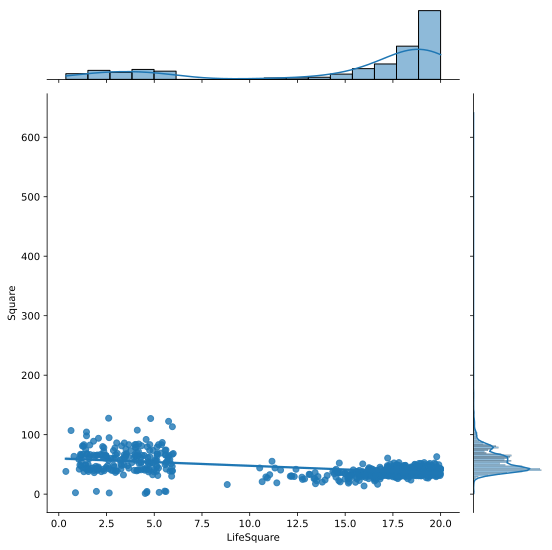

In [637]:
grid = sns.jointplot(train_df.loc[train_df['LifeSquare'] < 20, 'LifeSquare'], train_df['Square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

**Rooms**

In [638]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Кол-во комнат вне диапазона 1-5 будем считать выбросами

In [639]:
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] > 5)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
8794,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416


In [640]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1

Для квартир, где кол-во комнат >=6 или 0, посчитаем кол-во комнат, используя отношение среднего кол-ва комнат/среднюю величину
площади квартир. Умножим это отношение на площадь квартир.

In [641]:
train_df.loc[(train_df['Rooms'] >= 6) | (train_df['Rooms'] == 0), 'Rooms'] = round(train_df['Square']*\
                                                    (train_df['Rooms'].median()/train_df['Square'].median()))
train_df[train_df['Rooms_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2004,5927,57,2.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.323792,1
2194,3159,88,1.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,B,43,8429,3,NaN,3,9,B,158998.110646,1
2728,14865,9,2.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,...,B,25,5648,1,30.0,2,4,B,172329.270863,1
3780,7317,27,2.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,98129.976788,1
5894,770,28,2.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,...,B,30,6207,1,1183.0,1,0,B,217009.338463,1
6088,8491,1,2.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,B,1,264,0,NaN,0,1,B,78364.616704,1
6401,9443,27,3.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,219281.918007,1
7644,7917,27,8.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,302211.260887,1
7929,456,6,3.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,212864.799112,1
8794,14003,99,2.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,...,B,66,10573,1,1322.0,3,8,B,229661.964416,1


квартиру с index 9859 стоило бы удалить, но мы просто укажем кол-во комнат = 1

In [642]:
train_df.loc[(train_df['Rooms'] == 0), 'Rooms'] = 1

In [643]:
train_df['Rooms'].value_counts()

2.0    3886
1.0    3707
3.0    2237
4.0     150
5.0      19
8.0       1
Name: Rooms, dtype: int64

**KitchenSquare** 

In [644]:
train_df['KitchenSquare'].value_counts().sort_index()

0.0        697
1.0       2460
2.0          4
3.0         22
4.0         39
5.0       1169
6.0       1038
7.0        609
8.0       1306
9.0        843
10.0      1075
11.0       233
12.0       249
13.0        67
14.0        51
15.0        31
16.0        16
17.0        12
18.0         6
19.0        11
20.0        14
21.0         1
22.0         3
23.0         1
25.0         2
26.0         1
27.0         1
29.0         1
30.0         2
31.0         1
32.0         2
35.0         1
36.0         1
37.0         2
39.0         1
40.0         1
41.0         2
42.0         1
43.0         2
48.0         1
51.0         2
53.0         1
54.0         1
58.0         2
60.0         1
62.0         1
63.0         1
66.0         1
72.0         1
73.0         1
75.0         1
78.0         1
84.0         1
96.0         1
112.0        2
123.0        1
1970.0       1
2014.0       1
Name: KitchenSquare, dtype: int64

Возьмем за границу адекватности площадь кухни < 21 и >= 5. Посчитаем медиану для этих объектов. Для квартир с площадью кухни более 20 присвоим медиану, а для которых менее 5 присвоим 5.

In [645]:
KitchenSquare_median = train_df.loc[(train_df['KitchenSquare'] < 21) & (train_df['KitchenSquare'] > 4),\
                                    'KitchenSquare'].median()
KitchenSquare_median

8.0

In [646]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > 20)
        
train_df.loc[condition, 'KitchenSquare'] = KitchenSquare_median

train_df.loc[train_df['KitchenSquare'] < 5, 'KitchenSquare'] = 5

In [647]:
train_df['KitchenSquare'].value_counts()

5.0     4391
8.0     1354
10.0    1075
6.0     1038
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
15.0      31
16.0      16
20.0      14
17.0      12
19.0      11
18.0       6
Name: KitchenSquare, dtype: int64

**HouseFloor, Floor**

In [648]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [649]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [650]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [651]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [652]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [653]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [654]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [655]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

In [656]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [657]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### Обработка пропусков  <a class='anchor' id='nan'>

In [658]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

**LifeSquare**

Для пропусков жилой площади и площади менее 10 пересчитаем жилую площадь используя отношение средняя жилая площадь/средняя общая площадь. Отоношение жилой площади к общей получилось 0.6, что вполне соответствует нормам.

In [659]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna() | train_df['LifeSquare'] < 10) \
             & (~train_df['Square'].isna())

Square_LifeSquare_medians = train_df.loc[condition, 'LifeSquare'].median()/train_df.loc[condition, 'Square'].median()
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square']*Square_LifeSquare_medians
Square_LifeSquare_medians

0.6242466955442353

Не все красиво получилось, но оставим пока так. Квартиры с неадекватной общей площадью < 10 надо удалять, т.к. по графику выше было видно, что это выбросы, но тогда для test_df надо делать отдельную обработку, т.к. из нее объекты выбрасывать нельзя, заказчику надо предсказания для 5000 объектов.

In [660]:
train_df['LifeSquare'].value_counts().sort_index()

0.709680      1
1.241591      1
1.483989      1
1.620764      1
1.844217      1
             ..
132.922323    1
172.070658    1
255.582317    1
377.485705    1
400.182828    1
Name: LifeSquare, Length: 10000, dtype: int64

**Healthcare_1**

Сделаем предположение, что Healthcare_1 зависит от района DistrictId. С помощью ящика с усами видим похожее распределение, корреляция прямая с коэффициентом примерно 20.

<AxesSubplot:>

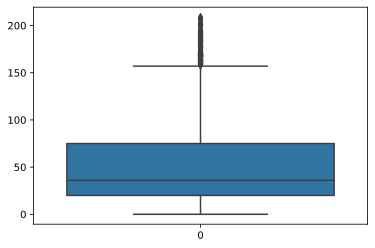

In [661]:
sns.boxplot(data=train_df['DistrictId'])

In [662]:
(train_df['DistrictId'].quantile(.75), train_df['DistrictId'].quantile(.25))

(75.0, 20.0)

<AxesSubplot:>

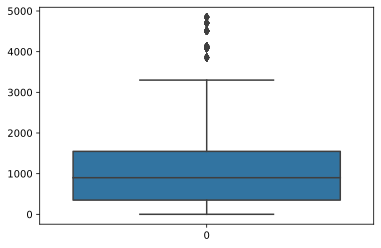

In [663]:
sns.boxplot(data=train_df['Healthcare_1'])

In [664]:
(train_df['Healthcare_1'].quantile(.75), train_df['Healthcare_1'].quantile(.25))

(1548.0, 350.0)

In [665]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df.loc[train_df['Healthcare_1'].isna(), 'DistrictId']*20

<AxesSubplot:>

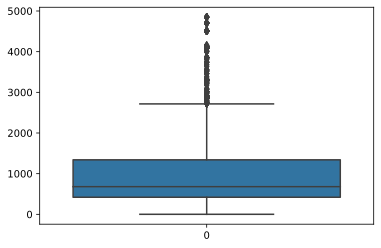

In [666]:
sns.boxplot(data=train_df['Healthcare_1'])

In [667]:
(train_df['Healthcare_1'].quantile(.75), train_df['Healthcare_1'].quantile(.25))

(1340.0, 420.0)

In [668]:
#train_df.drop('Healthcare_1', axis=1, inplace=True)

In [669]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.KitchenSquare_median = None
        self.square_lifesquare_medians = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет аргументов
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.KitchenSquare_median = X.loc[(X['KitchenSquare'] < 21) & (X['KitchenSquare'] > 4),\
                                    'KitchenSquare'].median()
        condition = (X['LifeSquare'].isna() | X['LifeSquare'] < 10) & (~X['Square'].isna())
        self.square_lifesquare_medians = X.loc[condition, 'LifeSquare'].median()/X.loc[condition, 'Square'].median()
    
    def transform(self, X):
        """Трансформация данных"""
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms'] = round(X['Square']*\
                                                                      (self.medians['Rooms']/self.medians['Square']))
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > 20)
        
        X.loc[condition, 'KitchenSquare'] = self.KitchenSquare_median

        X.loc[X['KitchenSquare'] < 5, 'KitchenSquare'] = 5
                 
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            #X.drop('Healthcare_1', axis=1, inplace=True)
            X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X.loc[X['Healthcare_1'].isna(), 'DistrictId']*20
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
               
        condition = (X['LifeSquare'].isna() | X['LifeSquare'] < 10) & (~X['Square'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square']*self.square_lifesquare_medians
                
        # Пропуски заменяем медианами
        X.fillna(self.medians, inplace=True)
        
        return X

### Построение новых признаков  <a class='anchor' id='feature'>

**Dummies**

In [670]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize**

In [671]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [672]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,71.805419,10.0,4,10.0,2014,0.075424,...,0,540.0,0,0,1,305018.871089,0,0,1,851
1,3013,22,1.0,39.832524,24.865321,8.0,7,8.0,1966,0.118537,...,1,1183.0,1,0,1,177734.553407,0,0,0,78
2,8215,1,3.0,78.342215,48.904869,10.0,2,17.0,1988,0.025609,...,0,240.0,3,1,1,282078.720850,0,0,0,652
3,2352,1,1.0,40.409907,25.225751,5.0,10,22.0,1977,0.007122,...,0,20.0,0,1,1,168106.007630,0,0,1,652
4,13866,94,2.0,64.285067,40.129741,9.0,16,16.0,1972,0.282798,...,2,1880.0,0,6,1,343995.102962,0,0,0,89


In [673]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictSize
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                    
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictSize
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        return X

### Отбор признаков  <a class='anchor' id='feature_selection'>

In [674]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize']

In [675]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'LifeSquare_nan', 'DistrictSize', 'new_district']

target_name = 'Price'

### Разбиение на train и test  <a class='anchor' id='split'>

In [676]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [677]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [678]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape, y_train.shape

((6700, 23), (3300, 23), (5000, 23), (6700,))

In [679]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape, y_train.shape

((6700, 25), (3300, 25), (5000, 25), (6700,))

In [680]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [681]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Модель

In [682]:
from sklearn import ensemble
from matplotlib import style
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

GridSearchCV - поиск лучших параметров для RandomForestRegressor

model2 = RandomForestRegressor(random_state=21)
param_grid = { "n_estimators"      : [50, 100, 200, 300, 500, 1000],
           "criterion"         : ["mse"],
           "max_features"      : [3, 5, 7, 9, 11],
           "max_depth"         : [10, 15, 20, 25],
           "bootstrap": [True, False]}
grid_search = GridSearchCV(model2, param_grid, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 3,
 'n_estimators': 300}

In [683]:
model1 = ensemble.GradientBoostingRegressor(n_estimators=250, max_depth=5, min_samples_split=17,
                                           learning_rate=0.1, loss='ls', random_state=21)

model2 = RandomForestRegressor(criterion='mse', random_state=21, max_features=3,\
                               n_estimators = 300, max_depth = 15, bootstrap = False)

model = VotingRegressor([('model1', model1), ('model2', model2)])

model.fit(X_train, y_train)

VotingRegressor(estimators=[('model1',
                             GradientBoostingRegressor(loss='ls', max_depth=5,
                                                       min_samples_split=17,
                                                       n_estimators=250,
                                                       random_state=21)),
                            ('model2',
                             RandomForestRegressor(bootstrap=False,
                                                   criterion='mse',
                                                   max_depth=15, max_features=3,
                                                   n_estimators=300,
                                                   random_state=21))])

Train R2:	0.947
Test R2:	0.771


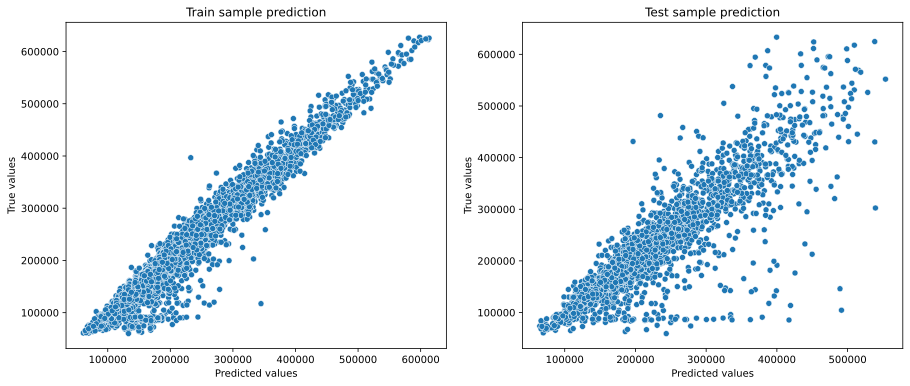

In [684]:
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

In [685]:
test_df.shape

(5000, 22)

In [686]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,new_district
0,1.0,36.847630,22.883504,5.0,5,9.0,1970,0.036122,1,1,...,0,1036.0,1,1,1,0,0,0,76.0,0
1,1.0,42.493907,26.390015,10.0,7,17.0,2017,0.072158,1,1,...,1,1240.0,0,0,0,0,0,0,164.0,0
2,2.0,59.463678,36.928762,9.0,19,19.0,1977,0.211401,1,1,...,0,540.0,0,1,1,0,0,1,580.0,0
3,3.0,49.646030,30.831702,6.0,2,2.0,1965,0.014073,1,1,...,0,460.0,0,0,1,0,0,0,372.0,0
4,1.0,53.837056,33.434457,5.0,8,17.0,1977,0.309479,1,1,...,4,990.0,0,6,1,0,0,1,65.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,26.814560,5.0,3,5.0,1962,0.069660,1,1,...,4,580.0,1,2,1,0,1,0,56.0,0
4996,3.0,93.698122,58.189398,10.0,21,27.0,2018,0.060753,1,1,...,2,520.0,0,7,1,0,0,0,26.0,0
4997,1.0,33.656723,20.901854,5.0,2,5.0,1966,0.038693,1,1,...,1,1015.0,2,5,1,0,0,0,54.0,0
4998,1.0,38.635155,23.993612,9.0,8,14.0,1970,0.089040,1,1,...,5,200.0,0,11,1,0,0,0,40.0,0


In [687]:
submit = pd.read_csv('reppm/sample_submission.csv')
submit

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0
...,...,...
4995,10379,200000.0
4996,16138,200000.0
4997,3912,200000.0
4998,5722,200000.0


In [688]:
predictions = model.predict(test_df)
predictions

array([162740.47569181, 127505.57774743, 144409.91745074, ...,
       146323.14387601, 195528.00734575, 280480.36191204])

In [689]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,162740.475692
1,5925,127505.577747
2,960,144409.917451
3,3848,126383.249591
4,746,194863.138087


In [690]:
submit.to_csv('rf_submit.csv', index=False)